In [2]:
import numpy as np
import pandas as pd 
from matplotlib import pyplot as plt
import os
import time 
from sklearn.preprocessing import OneHotEncoder

In [3]:
data = np.array(pd.read_csv("Datasets/digit-recognizer/train.csv"))
x_data, y_data = data[:, 1:data.shape[0]], data[:, 0:1]
indices = np.arange(len(x_data))
np.random.shuffle(indices)
x_data, y_data = x_data[indices], y_data[indices]

split = 0.9
idx = int(x_data.shape[0] * split)
trainx, trainy = x_data[:idx]/255., y_data[:idx]
x_validate, y_validate = x_data[idx:]/255., y_data[idx:]

In [4]:
def init_params():
    w1 = np.random.rand(16, 784) - 0.5
    b1 = np.random.rand(16, 1) - 0.5
    
    w2 = np.random.rand(16, 16) - 0.5
    b2 = np.random.rand(16, 1) - 0.5
    
    w3 = np.random.rand(10, 16) - 0.5
    b3 = np.random.rand(10, 1) - 0.5
    
    return w1, b1, w2, b2, w3, b3

In [5]:
def activation(func: str, z, backprop=False):
    if func == 'relu':
        if backprop:
            return z > 0
        return np.maximum(0, z)

    elif func == 'sigmoid':
        return 1 / (1 + np.exp(-z))

    elif func == 'softmax':
        exp_z = np.exp(z - np.max(z, axis=0, keepdims=True))
        return exp_z / np.sum(exp_z, axis=0, keepdims=True)

In [6]:
def forward_prop(param, x):
    w1, b1, w2, b2, w3, b3 = param
    # input layer to hidden layer 1
    z1 = w1.dot(x) + b1
    a1 = activation('relu', z1)
    # hidden layer 1 to hidden layer 2
    z2 = w2.dot(a1) + b2
    a2 = activation('relu', z2)
    # hidden layer 2 to output layer
    z3 = w3.dot(a2) + b3
    a3 = activation('softmax', z3)
    
    return z1, a1, z2, a2, z3, a3

In [7]:
def loss(func: str, y_predicted, labels):
    if func == 'cross_entropy':
        _, n = labels.shape
        epsilon = 1e-15
        y_predicted = np.maximum(epsilon, y_predicted)
        loss = -1/n * np.sum(labels * np.log(y_predicted))
        return loss

In [23]:
def back_prop(zanda, params, x, y):
    m, _ = x.shape
    z1, a1, z2, a2, z3, a3 = zanda
    w1, b1, w2, b2, w3, b3 = params
    
#     Last - da a3 - dw a2
#     Hidden - w3 - dz z2 - dw z1
#     Top - da w2 - dz z1

    # Output layer gradients
    dz3 = a3 - y 
    dw3 = 1 / m * dz3.dot(a2.T)
    db3 = 1 / m * np.sum(dz3)
    # Hidden layer 2 gradient
    dz2 = w3.T.dot(dz3) * activation('relu', z2, backprop=True)
    dw2 = 1 / m * dz2.dot(z1.T)
    db2 = 1 / m * np.sum(dz2)
    # Hidden layer 1 gradient
    dz1 = w2.T.dot(dz2) * activation('relu', z1, backprop=True)
    dw1 = 1 / m * dz1.dot(x.T)
    db1 = 1 / m * np.sum(dz1)
    
    return dw1, db1, dw2, db2, dw3, db3

In [9]:
def gradient_descent(param, gradient, learning_rate):
    w1, b1, w2, b2, w3, b3 = param
    dw1, db1, dw2, db2, dw3, db3 = gradient
    
    w1 -= learning_rate * dw1
    b1 -= learning_rate * db1
    w2 -= learning_rate * dw2
    b2 -= learning_rate * db2
    w3 -= learning_rate * dw3
    b3 -= learning_rate * db3
    
    return w1, b1, w2, b2, w3, b3

In [31]:
def accuracy(y_pred, y):
        predictions = np.argmax(y_pred, axis=0)
        acc = np.sum(predictions == y) / y.size
#         print(f"pp {predictions.shape}, {y.shape}, {y.size}")
        return acc

In [37]:
one_hot_y = OneHotEncoder().fit_transform(trainy).toarray()

In [41]:
params = init_params()
epoch = 1000
learning_rate = 0.01
for i in range(epoch):
    zanda = forward_prop(params, trainx.T)
    gradients = back_prop(zanda, params, trainx.T, one_hot_y.T)
    params = gradient_descent(params, gradients, learning_rate)
    if i % 100 == 0:    
        mloss = loss('cross_entropy', zanda[-1], one_hot_y.T)
        acc = accuracy(zanda[-1], trainy.T)
        print(f"loss: {mloss} - acc: {acc}")

loss: 3.0282442988469422 - acc: 0.11494708994708995
loss: 0.457281208537659 - acc: 0.8573015873015873
loss: 0.35627710795720025 - acc: 0.8886772486772487
loss: 0.5989053970814063 - acc: 0.8176984126984127
loss: 0.2796311472987478 - acc: 0.9159259259259259
loss: 0.251858018405018 - acc: 0.9248148148148149
loss: 0.24090880089301042 - acc: 0.9280952380952381
loss: 0.3362977770136752 - acc: 0.9003174603174603
loss: 0.21665085020641964 - acc: 0.9353703703703704
loss: 0.20019620956977527 - acc: 0.940026455026455


In [18]:
w1.shape

(10, 784)

In [21]:
# for i in model.params.keys():
#     print(f"{i}", model.params[i].shape)
for i in gradients:
    print(i.shape)

(10, 784)
()
(16, 16)
()
(10, 16)
()


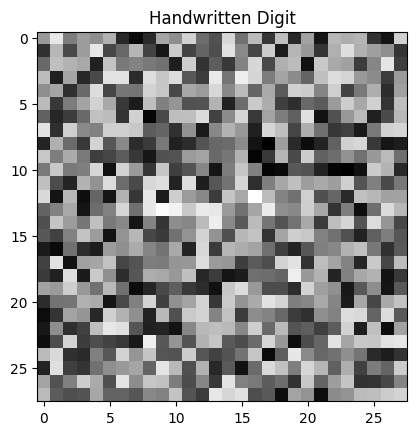

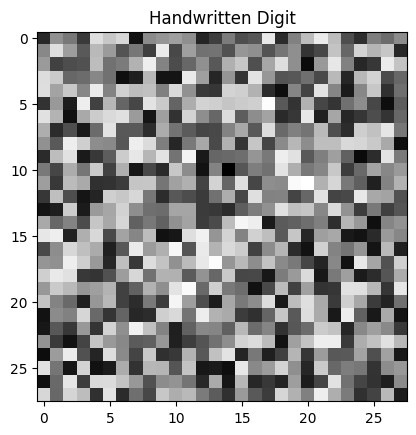

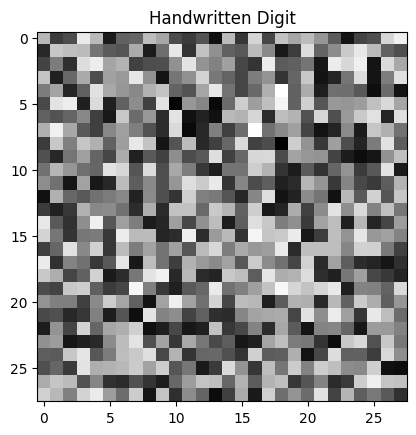

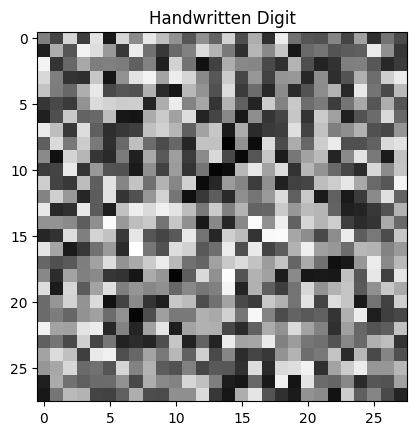

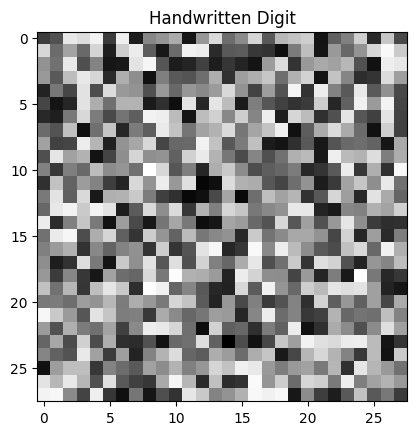

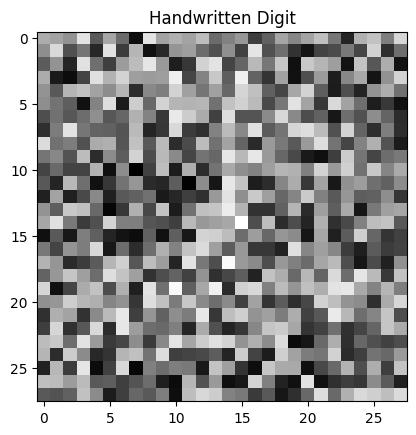

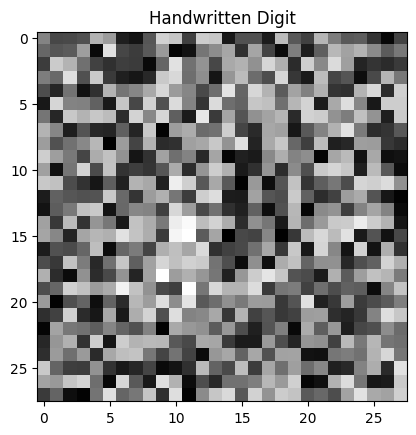

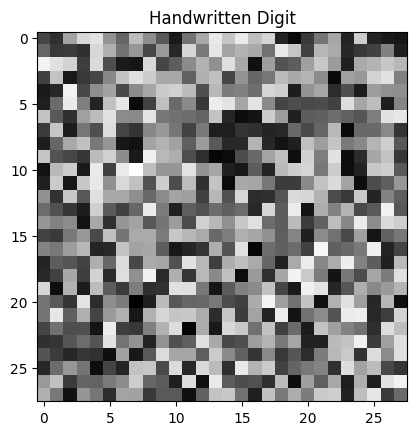

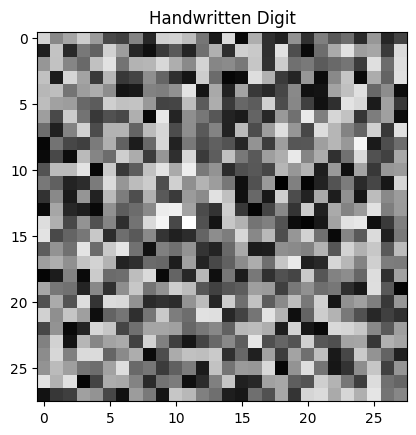

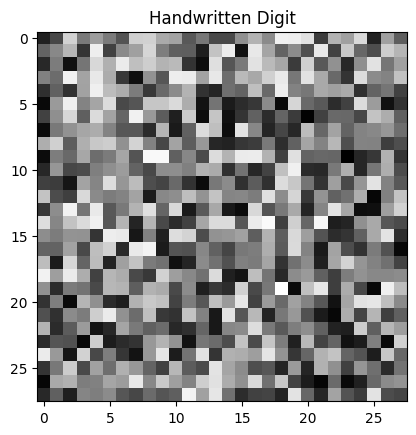

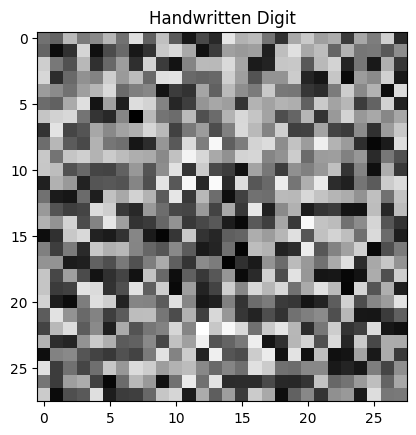

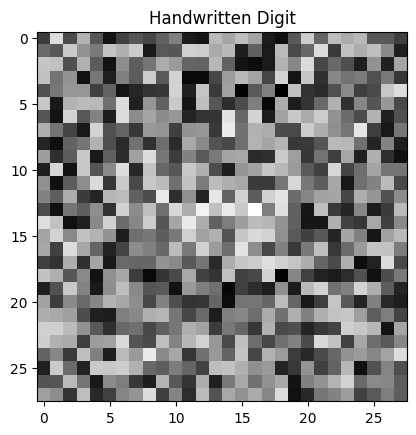

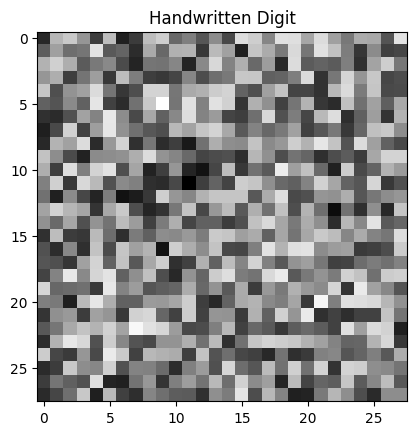

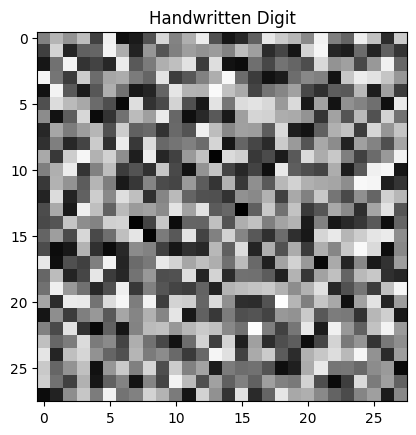

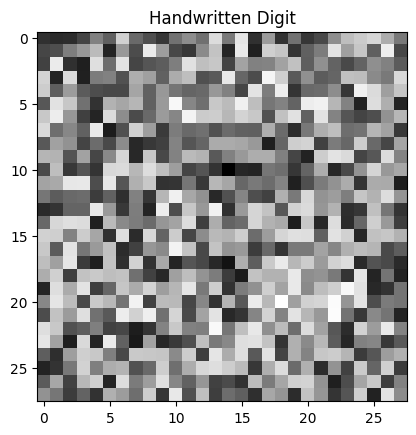

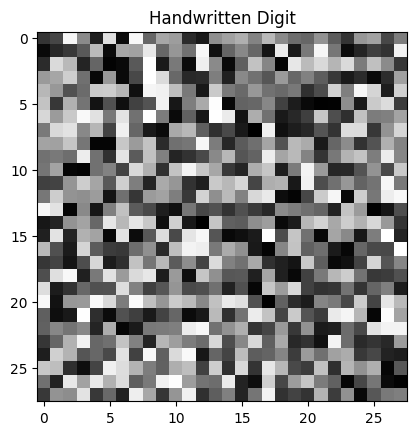

In [18]:
for i in range(0, 16):
    image_data = model.params['w1'][i]
    image_reshaped = image_data.reshape((28, 28))
    plt.imshow(image_reshaped, cmap='gray')
    plt.title('Handwritten Digit')
    plt.show()